In [213]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [214]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [215]:
filepath='file:////home/talentum/Project/Project_codes/10stocks_price.csv'
df = spark.read.option("header", True).csv(filepath)
df.show()

+------------------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+
|      date_gsheets| AAPL|   KO| NFLX|BRK.B|  DIS|   IBM|   VZ|  WMT|   GE| TSLA|
+------------------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+
|  01/03/2012 16:00|58.75|35.07|10.32|77.68|38.31| 186.3|39.73|60.33|18.36|28.08|
|  01/04/2012 16:00|59.06|34.85|11.49| 76.8|38.85|185.54|39.21|59.71|18.56|27.71|
|  01/05/2012 16:00|59.72|34.69|11.33|76.93| 39.5|184.66|38.94|59.42|18.55|27.12|
|  01/06/2012 16:00|60.34|34.47|12.33|76.39|39.91|182.54|38.33|   59|18.65|26.91|
|  01/09/2012 16:00|60.25|34.47|14.03|76.29|39.75|181.59|38.37|59.18|18.86|27.25|
|  01/10/2012 16:00|60.46|34.67|13.69|77.42|39.63|181.31|38.57|59.04|18.72|27.62|
|  01/11/2012 16:00|60.36|34.03|13.16|   78| 38.7|182.32| 38.9| 59.4|18.88|28.23|
|  01/12/2012 16:00| 60.2|33.78|13.16| 78.5|38.73|180.55|38.92| 59.5|18.93|28.25|
|1/13/2012 16:00:00|59.97|33.49|13.48|77.77| 38.4|179.16|38.92|59.54|18.84|22.79|
|1/17/2012 16:00

In [216]:
from pyspark.sql.functions import *
df = df.withColumn("date_gsheets",to_date(df.date_gsheets,"MM/dd/yyyy HH:mm"))
df = df.withColumnRenamed('BRK.B', 'BRK')
df.show()


+------------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+
|date_gsheets| AAPL|   KO| NFLX|  BRK|  DIS|   IBM|   VZ|  WMT|   GE| TSLA|
+------------+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+
|  2012-01-03|58.75|35.07|10.32|77.68|38.31| 186.3|39.73|60.33|18.36|28.08|
|  2012-01-04|59.06|34.85|11.49| 76.8|38.85|185.54|39.21|59.71|18.56|27.71|
|  2012-01-05|59.72|34.69|11.33|76.93| 39.5|184.66|38.94|59.42|18.55|27.12|
|  2012-01-06|60.34|34.47|12.33|76.39|39.91|182.54|38.33|   59|18.65|26.91|
|  2012-01-09|60.25|34.47|14.03|76.29|39.75|181.59|38.37|59.18|18.86|27.25|
|  2012-01-10|60.46|34.67|13.69|77.42|39.63|181.31|38.57|59.04|18.72|27.62|
|  2012-01-11|60.36|34.03|13.16|   78| 38.7|182.32| 38.9| 59.4|18.88|28.23|
|  2012-01-12| 60.2|33.78|13.16| 78.5|38.73|180.55|38.92| 59.5|18.93|28.25|
|  2012-01-13|59.97|33.49|13.48|77.77| 38.4|179.16|38.92|59.54|18.84|22.79|
|  2012-01-17|60.67|33.67|13.53|77.97|38.48|   180|39.02|59.85|18.74| 26.6|
|  2012-01-1

In [217]:
#Creating returns Dataframe

from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.sql import functions as F

return_df=df
my_window = Window.partitionBy().orderBy("date_gsheets")
for col_name in return_df.columns:
    if col_name!='date_gsheets':
     return_df = return_df.withColumn(col_name, F.when(F.isnull(col(col_name) - F.lag(col(col_name)).over(my_window)), 0)
                                      .otherwise(col(col_name) - F.lag(col(col_name)).over(my_window))/F.lag(col(col_name)).over(my_window))
for c in return_df.columns:
    if c!='date_gsheets':
        return_df = return_df.withColumn(c, F.round(c, 6))

return_df=return_df.dropna()
return_df.show()

+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|date_gsheets|     AAPL|       KO|     NFLX|      BRK|      DIS|      IBM|       VZ|      WMT|       GE|     TSLA|
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|  2012-01-04| 0.005277|-0.006273| 0.113372|-0.011329| 0.014096|-0.004079|-0.013088|-0.010277| 0.010893|-0.013177|
|  2012-01-05| 0.011175|-0.004591|-0.013925| 0.001693| 0.016731|-0.004743|-0.006886|-0.004857| -5.39E-4|-0.021292|
|  2012-01-06| 0.010382|-0.006342| 0.088261|-0.007019|  0.01038|-0.011481|-0.015665|-0.007068| 0.005391|-0.007743|
|  2012-01-09|-0.001492|      0.0| 0.137875|-0.001309|-0.004009|-0.005204| 0.001044| 0.003051|  0.01126| 0.012635|
|  2012-01-10| 0.003485| 0.005802|-0.024234| 0.014812|-0.003019|-0.001542| 0.005212|-0.002366|-0.007423| 0.013578|
|  2012-01-11|-0.001654| -0.01846|-0.038714| 0.007492|-0.023467| 0.005571| 0.008

In [218]:
#Calculating Variance Covariance Matrix

from pyspark.mllib.linalg.distributed import RowMatrix
return_df=return_df.drop('date_gsheets')
return_rdd = return_df.rdd.map(list)
return_row_mat = RowMatrix(return_rdd)
vcv_matrix=return_row_mat.computeCovariance()
#print(vcv_matrix)
#rows = vcv_matrix.toArray().tolist()
#vcv_df = spark.createDataFrame(rows,return_df.columns)
#for c in vcv_df.columns:
#    vcv_df=vcv_df.withColumn(c, col(c).cast(DecimalType(18, 6)))
#vcv_df.show()



In [219]:
# Estimating the risk of a 10 asset portfolio
num_stocks = 10
weights = [1 / num_stocks] * num_stocks  # vector (list) of weights

from pyspark.mllib.linalg import DenseMatrix
weight_matrix= DenseMatrix(1, num_stocks, weights)
weight_matrix_t= DenseMatrix(num_stocks, 1, weights)

from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.sql.functions import sqrt
weight_row_mat = RowMatrix(sc.parallelize(weight_matrix.toArray().tolist()))
vcv_w=weight_row_mat.multiply(vcv_matrix)
var_portfolio = vcv_w.multiply(weight_matrix_t).rows.collect()

# variance and standard deviation of portfolio

var_portfolio=var_portfolio[0][0]
sd_portfolio=np.sqrt(var_portfolio)
sd_portfolio_annual = sd_portfolio * np.sqrt(250)

In [220]:
# Extract a list of all the tickers in the dataframe
tickers = list(return_df.columns)
tickers

['AAPL', 'KO', 'NFLX', 'BRK', 'DIS', 'IBM', 'VZ', 'WMT', 'GE', 'TSLA']

In [221]:
# Create 10 portfolios with each ensuing portfolio comprising of ONE additional stock.
portfolios = []

for i in range(1, len(tickers) + 1):
    portfolios.append(tickers[0:i])

In [222]:
portfolios

[['AAPL'],
 ['AAPL', 'KO'],
 ['AAPL', 'KO', 'NFLX'],
 ['AAPL', 'KO', 'NFLX', 'BRK'],
 ['AAPL', 'KO', 'NFLX', 'BRK', 'DIS'],
 ['AAPL', 'KO', 'NFLX', 'BRK', 'DIS', 'IBM'],
 ['AAPL', 'KO', 'NFLX', 'BRK', 'DIS', 'IBM', 'VZ'],
 ['AAPL', 'KO', 'NFLX', 'BRK', 'DIS', 'IBM', 'VZ', 'WMT'],
 ['AAPL', 'KO', 'NFLX', 'BRK', 'DIS', 'IBM', 'VZ', 'WMT', 'GE'],
 ['AAPL', 'KO', 'NFLX', 'BRK', 'DIS', 'IBM', 'VZ', 'WMT', 'GE', 'TSLA']]

In [223]:
# Calculate the risk of each portfolio
from pyspark.mllib.linalg import DenseMatrix
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.sql.functions import sqrt
import numpy as np
    
portfolio_risks = []

for port in portfolios:
    df = return_df[port]
    return_rdd = df.rdd.map(list)
    return_row_mat = RowMatrix(return_rdd)
    vcv_matrix=return_row_mat.computeCovariance()
   
    
    num_stocks = len(df.columns)
    weights = [1 / num_stocks] * num_stocks  
    weight_matrix= DenseMatrix(1, num_stocks, weights)
    weight_matrix_t= DenseMatrix(num_stocks, 1, weights)
    weight_row_mat = RowMatrix(sc.parallelize(weight_matrix.toArray().tolist()))
    vcv_w=weight_row_mat.multiply(vcv_matrix)
    
    var_portfolio = vcv_w.multiply(weight_matrix_t).rows.collect()
    var_portfolio=var_portfolio[0][0]
    sd_portfolio=np.sqrt(var_portfolio)
    sd_portfolio_annual = sd_portfolio * np.sqrt(250)
    
    portfolio_risks.append(sd_portfolio_annual)

In [224]:
portfolio_risks

[0.24808515832540412,
 0.15361680771501215,
 0.21145654096896616,
 0.1749166036613368,
 0.1575916043340988,
 0.1457127097653313,
 0.13422932937280668,
 0.12628137558940866,
 0.12416651271890541,
 0.13539459014041144]

In [225]:
# Create a dataframe of all the portfolio risks

rdd=sc.parallelize(portfolio_risks)
risk_df=spark.createDataFrame(rdd.map(lambda x: float(x)), FloatType())
risk_df=risk_df.withColumnRenamed("value","Total_Risks")
risk_df.show()

+-----------+
|Total_Risks|
+-----------+
| 0.24808516|
|  0.1536168|
| 0.21145654|
| 0.17491661|
| 0.15759161|
|  0.1457127|
| 0.13422933|
| 0.12628138|
| 0.12416651|
| 0.13539459|
+-----------+



In [226]:
# Create a dataframe of all the portfolio risks together with protfolio columns

portfolio_df = spark.createDataFrame([(l,) for l in portfolios], ["Portfolios"])

# Add sequential index to both DataFrames
risk_df= risk_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
portfolio_df = portfolio_df.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))

# Join DataFrames on the index and drop the index column
portfolio_risk_df = portfolio_df.join(risk_df, "row_idx").drop("row_idx")

portfolio_risk_df = portfolio_risk_df.withColumn("Total_Risks", round(portfolio_risk_df["Total_Risks"], 6))

# Show the result
portfolio_risk_df.show(truncate=False)

+--------------------------------------------------+-----------+
|Portfolios                                        |Total_Risks|
+--------------------------------------------------+-----------+
|[AAPL]                                            |0.248085   |
|[AAPL, KO]                                        |0.153617   |
|[AAPL, KO, NFLX]                                  |0.211457   |
|[AAPL, KO, NFLX, BRK]                             |0.174917   |
|[AAPL, KO, NFLX, BRK, DIS]                        |0.157592   |
|[AAPL, KO, NFLX, BRK, DIS, IBM]                   |0.145713   |
|[AAPL, KO, NFLX, BRK, DIS, IBM, VZ]               |0.134229   |
|[AAPL, KO, NFLX, BRK, DIS, IBM, VZ, WMT]          |0.126281   |
|[AAPL, KO, NFLX, BRK, DIS, IBM, VZ, WMT, GE]      |0.124167   |
|[AAPL, KO, NFLX, BRK, DIS, IBM, VZ, WMT, GE, TSLA]|0.135395   |
+--------------------------------------------------+-----------+



In [227]:
# Compare the risk of portfolios with the risk of individual securities
data1=return_df.columns
data2=[]
for c in return_df.columns:
    data2.append(return_df.select(stddev(col(c)*np.sqrt(250))).collect()[0][0]) 
data = list(zip(data1, data2))
ind_risk_df=spark.createDataFrame(data,["Stocks","Risk"])
ind_risk_df = ind_risk_df.withColumn("Risk", round(ind_risk_df["Risk"], 6))
ind_risk_df.show()

+------+--------+
|Stocks|    Risk|
+------+--------+
|  AAPL|0.248085|
|    KO|0.137303|
|  NFLX|0.515473|
|   BRK|0.141077|
|   DIS|0.181373|
|   IBM|0.181766|
|    VZ|0.160274|
|   WMT|0.169338|
|    GE| 0.18454|
|  TSLA|0.482391|
+------+--------+



<AxesSubplot:title={'center':'Individual Risk of 10 stocks'}, xlabel='Stocks'>

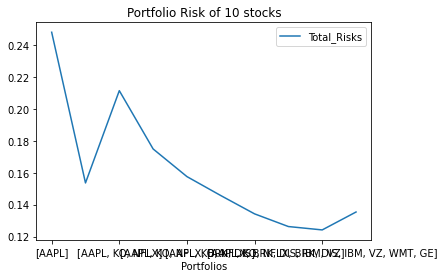

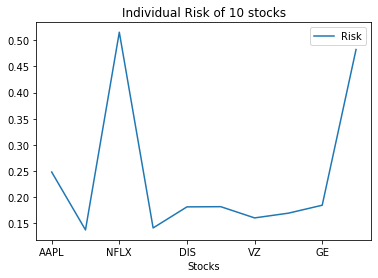

In [228]:
# Plot the portfolio risk of each of the 10 portfolios and individual risk


portfolio_risk_df.toPandas().plot.line(x="Portfolios", y="Total_Risks", title="Portfolio Risk of 10 stocks")
ind_risk_df.toPandas().plot.line(x="Stocks", y="Risk", title="Individual Risk of 10 stocks")